In [1]:
import os
import re

import csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

import data_processing as dp
import utils

In [2]:
# from scipy.sparse import spdiags,csc_matrix,linalg 

# def baseline_als(y, lam, p=0.5, niter=10):
#     L = len(y)
#     D = csc_matrix(np.diff(np.eye(L), 2))
#     w = np.ones(L)
#     for i in range(niter):        
# #         y = y.detach().numpy() if torch.is_tensor(y) else  y
        
#         W = spdiags(w, 0, L, L)
#         Z = W + lam * D.dot(D.transpose())
#         z = linalg.spsolve(Z, w*y)
#         w = p * (y > z) + (1-p) * (y < z)
#     return z

# y1=baseline_als(test_signal, 1e6)

In [3]:
# c13path="./C13/spectra-basic.csv"
# c15path="./C15/DatabaseAll.csv"
c15path="../../data/spectra/C15/Train_baseline_subtracted.csv"
plgaPath="../../data/spectra/C15/PLGA_baseline_subtracted.csv"

with open(c15path, 'r', encoding="utf-8", errors='replace') as file:
    reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
    data = list(reader)

    csv_basic = np.array(data)
    
with open(plgaPath, 'r', encoding="utf-8", errors='replace') as file:
    reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
    data = list(reader)

    csv_plga = np.array(data)


In [4]:
class Data:
    def __init__(self, label, data ):
        self.label = label
        self.data = data

    def __getitem__(self, index):
        return self.transform(self.data[index]), self.transform(self.label[index])


num_out_classes = 4
batch_size=32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from data_processing import data_normalize

print(csv_basic.shape)

print(len(csv_basic[0]))

def create_dataset(measurments,label):
    dataset=[]

    measurments = [i for i in measurments if i is not None]
    measurments=data_normalize(np.array(measurments))
    
    for measurment in measurments:
        dataset.append(Data(label,np.array(measurment)))

    print(np.array(dataset).shape)
    return dataset

index_split1= 500   # 1000, 500
index_split2= 900   # 6860, 900

glass_ds=create_dataset(csv_basic[:index_split1],0)
pmma_ds=create_dataset(csv_basic[index_split1:index_split2],1)
ps_ds=create_dataset(csv_basic[index_split2:],2)
plga_ds=create_dataset(csv_plga,3)

# si,pmma,ps -both

# (1300, 2048)
# 2048
# (500,)
# (400,)
# (400,)

(1300, 2048)
2048
(500,)
(400,)
(400,)
(190,)


In [6]:
# skip(baseline extraction takes longass time)
# import tf_dataset as ds # 
from tf_dataset import data_to_loader

# dataset=pmma_ds + ps_ds + glass_ds
dataset=pmma_ds + ps_ds + glass_ds + plga_ds

np.random.shuffle(dataset)
split_idx= int(len(dataset)*0.2)
batch_size=16

train_dataset = dataset[split_idx:]
test_dataset = dataset[:split_idx]

# _,_,target= data_to_loader(dataset,torch.float)
# training_loader,training_features,training_target = data_to_loader(train_dataset,torch.float)
# testing_loader,testing_features,testing_target = data_to_loader(test_dataset,torch.float)
def data_to_loader2(dataset,dtype,batch_size=1024):
    features=np.array([i.data for i in dataset])
    features=torch.tensor(features, dtype=dtype)

    target=np.array([i.label for i in dataset])
    target=torch.tensor(target, dtype=torch.int64)

    tensorDataset = data_utils.TensorDataset(features.to(device), target)
    loader = data_utils.DataLoader(tensorDataset, batch_size=batch_size, shuffle=False)

    return loader,features,target

_,_,target= data_to_loader2(dataset,torch.float)
training_loader,training_features,training_target = data_to_loader2(train_dataset,torch.float, batch_size=batch_size)
testing_loader,testing_features,testing_target = data_to_loader2(test_dataset,torch.float, batch_size=batch_size)

In [6]:
print(len(train_dataset))

1192


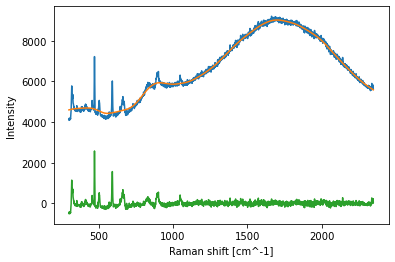

In [44]:
from matplotlib.pyplot import imshow
from data_processing import baseline_als

%matplotlib inline

test_signal= training_features[50]

# https://stackoverflow.com/questions/29156532/python-baseline-correction-library
    
features = np.array(pmma)
plt.plot(xaxis,features)

# plt.plot(test_signal)
plt.xlabel("Raman shift [cm^-1]")
plt.ylabel("Intensity ")
y1=baseline_als(features, 1e6)
plt.plot(xaxis,y1)
y2=np.subtract(features, y1)
plt.plot(xaxis,y2)


In [109]:
for i in training_loader:
    print(i[1].shape)
    print(i[1])
    print(i[0].shape)
    print(i[0])
    break

torch.Size([16])
tensor([2, 0, 3, 3, 2, 2, 2, 0, 1, 2, 1, 1, 0, 0, 0, 3])
torch.Size([16, 2047])
tensor([[-4.8504e-02, -4.0498e-02, -5.5592e-02,  ..., -1.3434e-04,
          5.4635e-03,  2.0823e-04],
        [-6.2569e-02, -6.3286e-02, -6.4838e-02,  ...,  1.2567e-02,
          1.0325e-02,  9.4638e-03],
        [-1.1954e+00, -1.2299e+00, -1.2559e+00,  ..., -2.1072e-02,
         -1.4662e-02,  2.6535e-02],
        ...,
        [-5.7004e-02, -2.8072e-02, -8.4712e-02,  ...,  1.2581e-01,
          9.9474e-02,  1.0973e-01],
        [-4.8338e-02, -3.7810e-02, -5.6403e-02,  ...,  3.6735e-02,
          4.8434e-02,  2.0234e-02],
        [-1.2707e+00, -1.2851e+00, -1.3296e+00,  ..., -2.3079e-02,
         -6.7560e-04,  1.8962e-02]])


In [8]:
infeatures=1
classes = np.unique(target)
nclasses = len(np.unique(target))

class Simple1DCNN(torch.nn.Module):
    def __init__(self,classes):
        super(Simple1DCNN, self).__init__()

        # self.bn1 = nn.BatchNorm1d(infeatures)
        
        self.layer1 = torch.nn.Conv1d(in_channels=1, out_channels=20, kernel_size=3, stride=2)
        self.act1 = torch.nn.ReLU()

#         self.layer2 = torch.nn.Conv1d(in_channels=20, out_channels=3, kernel_size=1)
        self.layer2 = torch.nn.Conv1d(in_channels=20, out_channels=1, kernel_size=1)
        self.act2 = torch.nn.ReLU()

        self.avgpool = nn.AdaptiveAvgPool1d(256)
        self.lin = nn.Linear(256, classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.avgpool(x)
        x = self.lin(x)
#         x = torch.flatten(x, start_dim=0, end_dim=-1) 
        return x
model = Simple1DCNN(classes)


TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [220]:
def test(data_loader, model, classes):
    loss_list=[]
    model = model.eval()

    # Accumulators
    loss_acc = 0
    correct = 0
    counter = 0
    batch_items = 0

    # Loop through dataset
    for batch_data in data_loader:

        # Calculate output      
        inputData =  batch_data[0][:, None, :] #TODO mode to dataprocessing
        groundtruth =  batch_data[1][:, None] #TODO mode to dataprocessing
        
        groundtruth= dp.one_hot_encode(groundtruth.reshape(-1, 1),([classes]))
        groundtruth= torch.tensor(groundtruth).float()
        
        output = model(inputData).squeeze()

        # Accumulate loss value
        # print(output.shape, batch_data[1].shape)
        lossOutput = loss(output, groundtruth)
        loss_list.append(lossOutput.item())

        # Calculate accuracy
        pred_y = torch.argmax(output,dim=1)
        label = batch_data[1]
        correct += (pred_y == label).sum().item()

        # Accumulate batch size (when batches don't have constant number items)
        counter +=  len(label)
        batch_items += 1

    model.train()
    return lossOutput / batch_items, correct / counter, loss_list



In [221]:
import sklearn.utils.class_weight as class_weight

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(target),
                                        y = target.numpy()                                                    
                                    )
class_weights=torch.tensor(class_weights,dtype=torch.float)
print(class_weights) #([0.8667, 1.0833, 1.0833])

tensor([0.7450, 0.9312, 0.9312, 1.9605])


In [9]:
import nets
import importlib
importlib.reload(dp)

criterion_weighted = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
loss = criterion_weighted                # criterion_weighted # nn.CrossEntropyLoss() / nn.NLLLoss() 

model = Simple1DCNN(len(classes)) # cnn1d_1 cnn1d_2
# model = nets.get_model("conv_1l", training_features[0].shape, classes) # dense
print(classes)
categories=['si', 'pmma', 'ps', 'plga']
optimizer = torch.optim.AdamW(model.parameters())#, lr=0.0002)

def train(training_loader,testing_loader,model,classes):
    print("Initializing...")

    loss_list=[]
    test_loss_list_histor=[]
    epochs=15

    model.to(device=device, dtype=torch.float)
    for e in range(epochs):
        for data in training_loader:

            inputData =  data[0][:, None, :] #TODO mode to dataprocessing
            groundtruth=  data[1] #TODO mode to dataprocessing

            groundtruth= dp.one_hot_encode(groundtruth.reshape(-1, 1),([classes]))
            groundtruth= torch.tensor(groundtruth).float()
            
            optimizer.zero_grad()
            out = model(inputData).squeeze()
#             pred = torch.argmax(out, dim=1)

#             print(out, groundtruth)
#             print(out.shape, groundtruth.shape)
            lossOutput = loss(out, groundtruth)
            loss_list.append(lossOutput.item())
            lossOutput.backward()
            optimizer.step()

            
        # Calculate loss and accuracy on the testing dataset
        test_loss_acc, acc, test_loss_list = test(testing_loader, model, classes)

        print(f"accuracy_score:{acc:.3f} "
          f"epoch:{e} "
          f"train_loss:{np.mean(loss_list):.3f} "
          f"test_loss:{test_loss_acc:.3f} ")

    # torch.save(model.state_dict(), path)
#     plt.plot(test_loss_list)
    print(f"Finished training loop"), # total time: {(time() - original_start_time):.2f} s.")
    return loss_list

loss_list= train(training_loader,testing_loader,model,classes)



2023-06-19 14:20:00.253627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-19 14:20:00.253676: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-19 14:20:00.326740: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-19 14:20:01.816305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-19 14:20:01.816447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

NameError: name 'class_weights' is not defined

In [10]:

save_path="./modelSimple1DCNN_15e.pt"  
torch.save(model.state_dict(), save_path)

x = range(len(loss_list))
y = loss_list
plt.plot(x, y)

x_ticks = [0, len(loss_list)//2, len(loss_list)]
x_labels = ['0', '10', '15'] 
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.xlabel("Epochs")

fig1 = plt.gcf()
fig1.savefig('./trainLoss.png', dpi=100)

NameError: name 'model' is not defined

In [11]:

classes=["glass","pmma","ps"]
iter=0
y_test_list=[]
y_pred_list=[]

categories=['si', 'pmma', 'ps', 'plga']
model = Simple1DCNN(len(categories)) 
model.load_state_dict(torch.load("./modelSimple1DCNN_15e.pt"))
testing_loader,testing_features,testing_target = data_to_loader2(test_dataset,torch.float,batch_size=1)

for x,y in testing_loader:
    iter+=1
    # Calculate output      
    x =  x[:, None, :] #TODO mode to dataprocessing
    y =  y[:, None] #TODO mode to dataprocessing
    output = model(x)
    
    # Calculate accuracy
    
    pred_y = torch.argmax(output)
    label = y

    y_pred_list.append(pred_y.numpy())
    y_test_list.append(label.numpy())

#         print("predicted:"+classes[pred_y]+"\nlabel:"+classes[label])
#         if not(pred_y == label):
#             print("             -INCORRECT",classes[pred_y])
#     if (iter >= 5):
#         break

y_pred= np.array(y_pred_list).squeeze()
y_test= np.array(y_test_list).squeeze()

print(y_pred.shape,y_test.shape)

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


(298,) (298,)


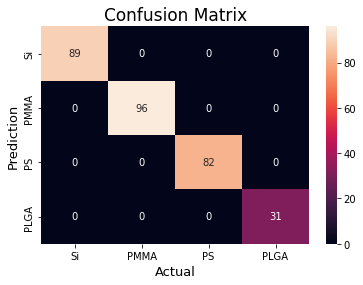

Accuracy   : 1.0


<Figure size 432x288 with 0 Axes>

In [12]:
# https://www.jcchouinard.com/confusion-matrix-in-scikit-learn/
# %pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score


# Compute the confusion matrix
cm = confusion_matrix(y_pred,y_test)

x_axis_labels = ["Si","PMMA","PS","PLGA"]
y_axis_labels = ["Si","PMMA","PS","PLGA"]
# y_axis_labels = ["glass","pmma","ps"]

# Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
           fmt='d',
           xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

fig1 = plt.gcf()
plt.show()

plt.draw()
fig1.savefig('./modelSimple1DCNN_e15_CM.png', dpi=100)
fig1.savefig('./modelSimple1DCNN_e15_CM.jpg',bbox_inches='tight', dpi=fig1.dpi)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)

In [ ]:
# https://www.jcchouinard.com/confusion-matrix-in-scikit-learn/
# %pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score

# Compute the confusion matrix
cm = confusion_matrix(y_pred,y_test)

x_axis_labels = ["glass","pmma","ps"]
y_axis_labels = ["glass","pmma","ps"]

# Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
           fmt='d',
           xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

fig1 = plt.gcf()
plt.show()

plt.draw()
fig1.savefig('./modelSimple1DCNN_e10_CM.png', dpi=100)
fig1.savefig('./modelSimple1DCNN_e10_CM.jpg',bbox_inches='tight', dpi=fig.dpi)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)

In [58]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow

%matplotlib inline

pix=[(0,0,255),(0,255,0),(255,0,0),(255,255,255)] #,(0,0,0)
pic=np.empty(shape=(81,121,2048))

def arr2data(arr):
  features=np.array(arr)
  features=torch.tensor(np.array(arr))

  tensorDataset = data_utils.TensorDataset(features.to(device), np.empty(shape=(126,126)))
  loader = data_utils.DataLoader(tensorDataset, batch_size=batch_size, shuffle=False)
  return loader

def text_read(path): # todo multiple lines
  with open(path, 'r', encoding="utf-8", errors='replace') as file:
      for row in file:
        arr=row.split(' ')
        arr = np.array(arr[:-1]).astype(np.float32)
  return arr



In [59]:
def plot_measure(arr):
  ax = plt.gca()
  if len(arr)>1000:
    ax.set_ylim([0, 2048])
    ax.set_ylim([0, 15000])
  else:
    ax.set_ylim([0, 512])
  plt.plot(arr)
  

In [73]:
path_to_pic="../../data/spectra/C15/txt/pic2_81x121/txt_pixels/"
for root, dirs, files in os.walk(path_to_pic, topdown=False):
    for name in files:
#       print(name)
      try:
        if name.find("txt")!= -1 : #todo:there's gotta be a better way to do this
            arr=[]
            idxs=re.findall(r'\d+', name)
            path=os.path.join(root, name)
            arr= text_read(path)

            pic[int(idxs[0])][int(idxs[1])] = arr
            #       break
      except:
        print(name)
        print(int(idxs[0]),int(idxs[1]))

(81, 121, 2048)
(9801, 2048)
(81, 121, 2048)
(9801, 2048)
[0.01446863 0.01462704 0.01443263 ... 0.01792829 0.0182811  0.01803629]
[4204. 4239. 4204. ... 8336. 8444. 8357.]


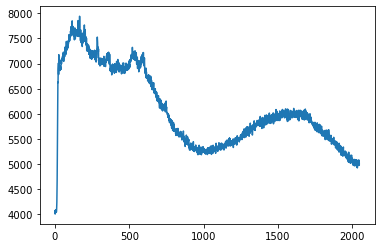

In [74]:
# print(pic.shape)
# new_pic = pic.reshape(-1, pic.shape[-1])  # flatten 128x128 to 1 dimension
# new_pic = normalized(new_pic,1)
# print(new_pic.shape)


In [13]:

print(pic[0][0])
print(pic.shape)

pic_fin=np.empty(shape=(126,126,3))

new_pic = pic.reshape(-1, pic.shape[-1])  # flatten 128x128 to 1 dimension
new_pic = normalized(new_pic,1)
new_pic = new_pic.reshape(-1, 4, new_pic.shape[0]).mean(axis = 1)  #average every 4 values in each measurement 
new_pic=np.transpose(new_pic,(1,0))  #shift dimensions

for i,measure in enumerate(new_pic):
  # print(len(measure))
  # print(measure)

  # print(data.shape)
  measure = np.array(measure).astype(np.float32)
  data= torch.tensor(measure)
  data= data[ None,:] 
  print(data.shape)
  print(data)

  model = model.eval()
  output = model(data)
  pred_y = torch.argmax(output,dim=1)
  
  print(pred_y)
  pic_fin[i][i//126] = pix[pred_y] #pred_y.argmax()

  break


# Convert the pixels into an array using numpy
array = np.array(pic, dtype=np.uint8)
new_pic = new_pic.reshape(126,126,512)
print(new_pic.shape)

# Use PIL to create an image from the new array of pixels
# new_image = Image.fromarray(array)
# new_image.save('new.png')

# imshow(np.asarray(new_image))

[0. 0. 0. ... 0. 0. 0.]
(126, 126, 2048)
torch.Size([1, 512])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

NameError: name 'model' is not defined

In [ ]:
for i in training_loader:
  print(i[1].shape)
  print(i[1])
  print(i[0].shape)
  print(i[0].shape)
  break

In [12]:

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

A = np.random.randn(3)
print(A)
print(normalized(A,0))


[-2.15743599 -0.0166586  -0.05492746]
[[-0.99964628 -0.00771875 -0.02545059]]


In [ ]:

            # arr = normalized(arr)
            # arr = np.mean(arr.reshape(-1, 4), axis=1)


            # # print(len(arr))
            # data= torch.tensor(arr)
            # data= data[ None,:] 
            
            # # print(data.shape)
            # model = model.eval()
            # output = model(data)
            # pred_y = torch.argmax(output,dim=1)

            # print(data.shape)
            # print(data)
            # print(pred_y)
            # print(pred_y[0])
            # # print(pix[pred_y])
            # # np.insert(pic, [int(idxs[0]),int(idxs[1])], pix[pred_y]) 
            # np.insert(pic, [int(idxs[0]),int(idxs[1])], pred_y*50)    
            
            # # pic[int(idxs[0])][int(idxs[1])] = pred_y*100 #pred_y.argmax()

In [ ]:
pmma=[]
ps=[]
glass=[]

for root, dirs, files in os.walk("/content/train", topdown=False):
    for name in files:
      full_path=os.path.join(root, name)

      if full_path.find("PMMA") != -1 and full_path.find("*") == -1:
        pmma.append(text_read(full_path))
      if full_path.find("PS") != -1 :  
        ps.append(text_read(full_path))
      if full_path.find("SI") != -1 :  
        glass.append(text_read(full_path))

glass_ds=create_dataset(pmma,0)
pmma_ds=create_dataset(ps,1)
ps_ds=create_dataset(glass,2)

np.random.shuffle(dataset)
split_idx= int(len(dataset)*0.2)

train_dataset = dataset[split_idx:]
test_dataset = dataset[:split_idx]

training_loader2,training_features2,training_target2 = data_to_loader(train_dataset,torch.float)
testing_loader2,testing_features2,testing_target2 = data_to_loader(train_dataset,torch.float)

In [ ]:
# cnn1d_1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, stride=1)
cnn1d_2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2)

# model = cnn1d_1.to(device=device, dtype=torch.float)
model = cnn1d_2.to(device=device, dtype=torch.float)

for i in training_loader:
    print("batch and input: "+str(i[0].shape))
    i[0] =  i[0][:, None, :]
    print(str(i[0].shape))

    out=model(i[0])
    print("batch and output: "+str((out.shape)))
    print("batch and gt: "+str((i[1]).shape))
    break

(2047,)


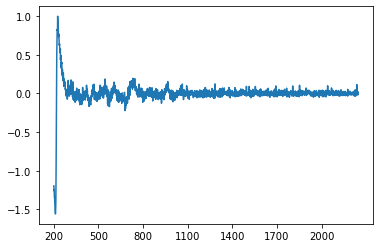

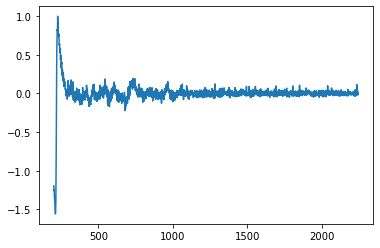

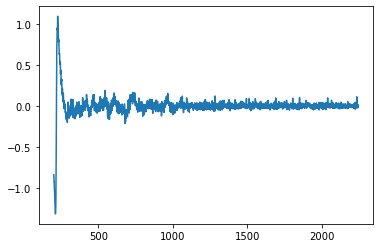

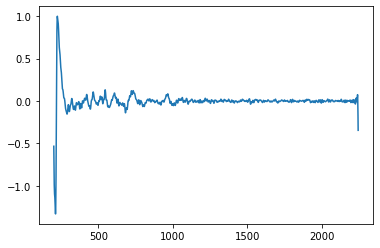

In [23]:
### sample images for BP
# c15path="../../data/spectra/DatabaseAll.csv"

# with open(c15path, 'r', encoding="utf-8", errors='replace') as file:
#     reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
#     data = list(reader)

#     csv_all = np.array(data)
    
idx=1489  #450 700 1200

# dataset=csv_all
dataset=pmma_ds + ps_ds + glass_ds + plga_ds
measurement= dataset[idx].data

features = np.array(measurement.data)
featuresN = measurement/measurement.max()
baseline = np.array(dp.baseline_als(featuresN, 1e6))
featuresBLsubtracted = np.subtract(featuresN, baseline)
lpfFeatures = dp.low_pass_filter(featuresBLsubtracted)

#     features=normalized(features)
#     features=torch.tensor(features, dtype=dtype)
# target=np.array(measurement.label)

classes=["si","pmma","ps","plga"]
# print(dataset.shape)
print(features.shape)
fig, axs = plt.subplots(1,1) 
plt.plot(range(200,len(features)+200),features)
axs.set_xticks(range(200,len(features,),300))
axs.set_xticklabels(range(200,len(features,),300))
# axs.set_xticklabels([200,len(features)//2,len(features)])
# plt.xticks(range(200,len(features)),[200,len(features)//2,len(features)])
plt.savefig('./original'+str(classes[int(idx//450)])+'.png')
plt.show()

plt.plot(range(200,len(features)+200),featuresN)
axs.set_xticks(range(200,len(features,),300))
axs.set_xticklabels(range(200,len(features,),300))
plt.savefig('normalized'+str(classes[int(idx//450)])+'.png')
plt.show()

plt.plot(range(200,len(features)+200),featuresBLsubtracted)
axs.set_xticks(range(200,len(features,),300))
axs.set_xticklabels(range(200,len(features,),300))
plt.savefig('baselineSub'+str(classes[int(idx//450)])+'.png')
plt.show()

plt.plot(range(200,len(features)+200),lpfFeatures)
axs.set_xticks(range(200,len(features,),300))
axs.set_xticklabels(range(200,len(features,),300))
plt.savefig('baselineSubLPF'+str(classes[int(idx//450)])+'.png')
plt.show()
## 500 900 1300 1490

In [72]:

c15path="../../data/spectra/DatabaseAll.csv"
# c15path="../../data/spectra/Train_baseline_subtracted.csv"

with open(c15path, 'r', encoding="utf-8", errors='replace') as file:
    reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
    data = list(reader)

    csv_all = np.array(data)
    

In [7]:

idx=1100  #450 700 1200

# dataset=pmma_ds + ps_ds + glass_ds + plga_ds
measurement= dataset[idx]
print(np.array(dataset.data).shape)

features = np.array(measurement.data)
classes=["si","pmma","ps"]

si=np.array(dataset[:500,:].data)
pmma=np.array(dataset[500:900,:].data)
ps=np.array(dataset[900:,:].data)

idx0=1
samples=[si[idx0],pmma[idx0],ps[idx0]]

for i,sample in enumerate(samples):
    featuresN = data_normalize(sample)
    baseline = np.array(dp.baseline_als(featuresN, 1e6))
    featuresBLsubtracted = np.subtract(featuresN, baseline)
    lpfFeatures = dp.low_pass_filter(featuresBLsubtracted)

    print(lpfFeatures.shape)
    xaxis=np.arange(300,len(lpfFeatures)+300)
    plt.plot(xaxis,featuresN)
    plt.plot(xaxis,baseline)
    plt.plot(xaxis,featuresBLsubtracted)
    plt.savefig(classes[i]+'_fixed.png')
    plt.show()


AttributeError: 'list' object has no attribute 'data'

(2048,)


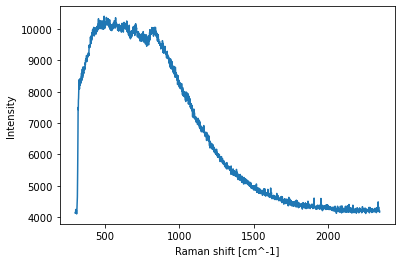

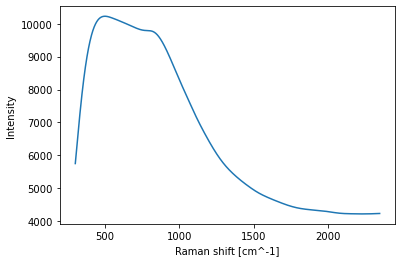

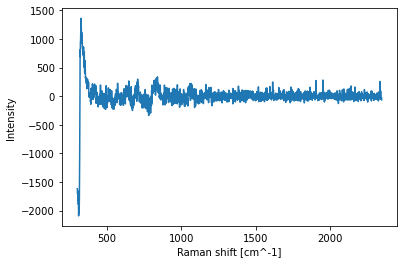

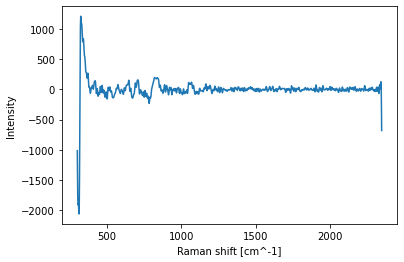

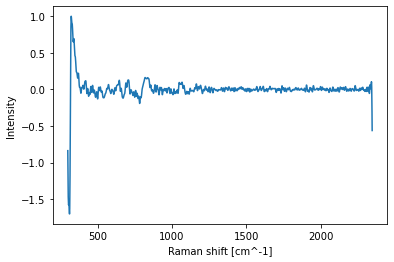

In [42]:
import importlib
importlib.reload(dp)

pmma=[4124,4120,4087,4197,4133,4171,4141,4169,4135,4122,4187,4157,4312,4394,4509,4605,4939,5130,5399,5781,5346,5377,5398,5226,5343,5163,5353,5090,4965,4913,4901,4843,4743,4732,4772,4629,4674,4666,4611,4598,4638,4591,4636,4543,4626,4612,4593,4643,4570,4546,4550,4670,4634,4808,4541,4574,4524,4616,4549,4571,4608,4576,4624,4600,4598,4563,4577,4604,4573,4604,4565,4590,4561,4523,4521,4583,4509,4488,4548,4667,4636,4495,4607,4641,4621,4763,4648,4680,4699,4753,4685,4602,4669,4701,4607,4612,4589,4679,4541,4656,4544,4625,4679,4666,4651,4679,4608,4637,4794,4755,4817,4867,4888,4779,4825,4821,4842,4780,4739,4741,4654,4651,4745,4649,4702,4670,4607,4593,4634,4635,4550,4629,4623,4583,4658,4545,4572,4532,4643,4645,4546,4611,4563,4557,4510,4609,4632,4613,4606,4658,4629,4661,4686,4674,4775,4817,5065,4919,4849,4801,4739,4740,4728,4720,4686,4630,4590,4620,4680,4807,5413,6459,7225,6512,5468,4786,4530,4478,4511,4453,4421,4407,4383,4484,4463,4465,4471,4497,4476,4428,4459,4462,4457,4342,4630,4429,4481,4564,4592,4656,4744,4890,4948,4990,5068,4936,4938,4800,4678,4551,4501,4399,4380,4329,4372,4347,4319,4345,4296,4276,4347,4289,4342,4339,4335,4247,4337,4281,4311,4314,4239,4241,4274,4229,4284,4183,4197,4191,4334,4224,4191,4316,4188,4169,4211,4260,4277,4201,4141,4246,4172,4280,4272,4187,4255,4223,4195,4275,4261,4321,4326,4240,4172,4265,4241,4264,4245,4248,4217,4306,4288,4501,4231,4263,4344,4300,4351,4367,4321,4438,4313,4454,4361,4392,4377,4479,4513,4686,4893,5211,5564,5997,6025,5734,5117,4788,4625,4465,4437,4296,4314,4359,4383,4373,4442,4375,4393,4353,4345,4368,4360,4336,4345,4378,4274,4444,4255,4334,4315,4380,4424,4365,4449,4363,4390,4434,4344,4324,4439,4429,4416,4396,4437,4416,4441,4474,4479,4421,4508,4488,4475,4507,4509,4464,4619,4770,4592,4600,4666,4630,4694,4647,4663,4719,4795,4913,4945,4952,5048,5112,5093,5030,4973,5255,4969,5058,4848,5024,4963,5038,4935,4964,4948,4896,4766,4708,4573,4560,4481,4514,4443,4357,4332,4386,4351,4370,4389,4373,4627,4473,4423,4364,4490,4423,4406,4368,4464,4445,4473,4474,4510,4474,4499,4492,4517,4497,4690,4580,4542,4561,4613,4517,4540,4563,4546,4595,4590,4544,4635,4620,4665,4712,4574,4728,4681,4712,4742,4725,4751,4795,4791,4907,4825,4815,4821,4737,4807,4796,4788,4755,4669,4773,4877,4752,4820,4857,4762,4823,4888,4828,4797,4907,4859,4837,4939,4889,4843,4931,4906,4921,5064,4983,5047,4956,4994,4955,4994,5077,5031,5063,5005,4970,4954,5016,4978,5092,4996,5070,5179,5021,4980,5132,5054,5137,5123,5116,5159,5155,5150,5170,5237,5235,5201,5216,5262,5271,5304,5266,5344,5311,5280,5309,5483,5448,5429,5433,5338,5407,5338,5425,5436,5534,5533,5501,5595,5621,5592,5597,5653,5678,5757,5749,5667,5724,5836,5748,5785,5764,5858,5782,5834,5957,5813,5804,5746,5892,5846,5877,5823,5938,5804,5717,5813,5840,5871,5916,5797,5778,5695,5708,5818,5696,5827,5787,5757,5786,5718,5753,5814,5765,5802,5739,5870,5816,5856,5685,5882,5733,5730,5760,5745,5645,5705,5744,5722,5639,5626,5796,5716,5913,5753,5920,5821,5849,5899,6064,6142,6127,6168,6204,6204,6404,6248,6330,6357,6444,6395,6339,6308,6250,6319,6356,6491,6267,6086,6147,6102,6082,6005,6039,5963,6015,6025,6025,5989,5955,5893,5916,5980,5874,5914,5825,5829,5822,5830,5844,5932,5807,5837,5956,5803,5931,5796,5860,5923,5785,5819,5873,5751,5826,5880,5831,5918,5801,5906,5857,5776,5773,5704,5779,5876,5819,5771,5780,5793,5729,5687,5681,5851,5707,5736,5748,5750,5926,5792,5840,5775,5802,5769,5853,5821,5759,5761,5833,5756,5868,5952,5722,5742,5859,5772,5867,5858,5720,5839,5793,5792,5864,5790,5905,5817,5814,5894,5776,5739,5842,5890,5913,5890,5826,5843,5795,5815,5750,5816,5806,5827,5859,5909,5871,5818,5888,5814,5806,5829,5952,5801,5789,5812,5801,5787,5876,5927,5933,5888,5885,5871,5802,5842,5783,6013,5870,5854,5842,5877,5958,5860,5839,5848,5808,5961,5879,6020,6048,6053,6041,6140,6049,6312,6097,6181,6067,6090,6060,6107,6012,6052,6028,6057,5973,5867,5838,5928,5938,6007,5835,5923,5851,5946,5767,5896,5883,5839,5879,5837,5916,5912,5936,5953,5860,5966,5809,5908,5934,5962,5947,5842,5982,5880,5877,5820,5918,5967,5827,5876,5812,5840,6091,5981,5923,5901,5935,5890,6003,5879,5962,6004,5951,6015,5931,5974,6067,5967,5959,5918,6010,6024,6051,6021,5979,6032,6047,5967,6041,6024,6060,6044,6084,5907,6033,6041,6029,6063,6026,6096,6086,6009,6173,6034,6027,6085,6112,6098,6195,6177,6132,6072,6177,6064,6174,6217,6156,6148,6266,6156,6165,6174,6179,6201,6131,6162,6201,6159,6225,6381,6277,6154,6254,6203,6192,6358,6269,6129,6237,6363,6323,6301,6263,6214,6364,6223,6300,6318,6250,6327,6266,6289,6337,6442,6291,6290,6335,6423,6523,6262,6268,6295,6256,6432,6333,6323,6368,6348,6369,6360,6234,6326,6401,6373,6406,6377,6386,6511,6411,6477,6459,6429,6461,6434,6468,6369,6515,6414,6597,6488,6518,6459,6451,6569,6427,6468,6519,6499,6490,6472,6610,6481,6538,6528,6735,6482,6586,6535,6576,6562,6575,6597,6735,6579,6519,6609,6632,6485,6610,6711,6701,6632,6467,6710,6618,6631,6693,6591,6685,6710,6759,6789,6774,6617,6799,6650,6700,6630,6750,6700,6770,6628,6779,6757,6806,6802,6693,6870,6930,6815,6723,6882,6749,6893,6868,6800,6806,6793,6801,6833,6826,6748,6852,6832,6747,7046,6950,6916,6840,7053,6911,7093,6916,6972,6919,6910,7066,6912,6948,7054,7042,6979,7195,7065,7048,7015,7117,7115,7103,7173,7046,7178,7124,7092,7081,7247,7096,7201,7209,7185,7197,7210,7150,7250,7146,7136,7164,7187,7160,7126,7256,7139,7293,7408,7238,7223,7213,7196,7319,7287,7212,7293,7363,7444,7429,7378,7372,7420,7382,7509,7478,7447,7429,7506,7395,7440,7286,7463,7465,7472,7463,7469,7387,7482,7505,7455,7535,7509,7519,7799,7634,7523,7537,7667,7519,7613,7592,7629,7604,7606,7582,7517,7593,7547,7632,7606,7613,7640,7784,7731,7694,7650,7795,7783,7802,7757,7647,7663,7729,7753,7902,7767,7758,7876,7830,7844,8023,7813,7945,7724,7844,7860,7863,7893,7874,7676,7916,7919,8025,7938,7964,7840,7824,8031,7928,7849,7804,7831,7975,8030,7953,7984,8044,7930,8017,8077,8092,8046,8016,8022,8268,8077,8101,8079,8138,8053,8039,8087,8138,8119,8176,8120,8179,8211,8324,8130,8057,8039,8010,8161,8154,8101,8187,8243,8160,8253,8167,8140,8262,8224,8122,8319,8200,8186,8219,8142,8161,8194,8309,8199,8322,8171,8191,8211,8248,8295,8166,8115,8248,8316,8354,8388,8400,8430,8306,8254,8328,8297,8373,8355,8332,8348,8323,8609,8453,8288,8237,8537,8425,8427,8383,8492,8404,8288,8375,8469,8494,8358,8415,8410,8472,8455,8419,8373,8413,8494,8546,8375,8499,8482,8631,8539,8607,8634,8464,8544,8715,8515,8750,8611,8511,8539,8580,8564,8539,8556,8614,8675,8727,8670,8600,8638,8604,8734,8812,8671,8660,8750,8663,8947,8541,8727,8789,8832,8769,8723,8698,8649,8691,8620,8725,8863,8739,8791,8719,8782,8840,8801,8890,8790,8966,8748,8776,8800,8830,8745,8863,8770,8803,8727,8829,8787,8887,8812,9015,8841,8731,8737,8829,9007,8879,8954,8853,8808,8994,8861,8812,8762,8759,8851,8796,8927,8899,8844,8941,8908,8911,8946,8709,9013,8801,8828,8819,8978,8888,8895,9050,8939,8845,8992,8865,8887,8998,8963,9040,8925,8958,8950,8997,9073,9056,8890,8915,9004,9034,9085,9077,9042,9211,9045,8927,9130,8964,9078,8937,9124,9109,9010,9126,8978,9028,8929,9007,9150,9007,8981,9121,9024,9093,9046,9040,9072,9182,9142,9110,8979,9175,9062,9114,9013,9042,9075,9010,9147,9058,8991,9050,9062,9032,8965,9101,9053,8992,9089,9069,9129,8895,9100,8978,9114,9010,9148,9073,9156,8956,9005,8999,8885,9059,9065,8950,8969,9087,9037,9054,9095,8882,8931,8868,9028,8913,9012,8977,8952,8977,9116,8974,8983,8939,8941,8921,8948,9027,8915,8929,8943,8836,8791,8950,8973,9044,8936,8910,8916,8926,9018,9016,8964,8836,9064,8843,8878,9020,8871,8987,8822,8858,8875,8776,8942,8852,8909,8931,8992,8822,8845,8863,8876,8870,8885,8856,8947,8983,8809,8843,8833,8764,9011,8830,8807,9009,8816,8800,8832,8848,9004,8849,8910,8823,8853,8908,8836,8896,8774,8856,8912,8930,8947,8850,8868,8899,8914,8888,8828,8841,8826,8902,8837,8831,8976,8832,8896,8806,8797,8739,8830,8884,9001,8911,8944,8852,8903,8735,8834,8820,8896,8739,8742,8839,8772,8860,8738,8930,8745,8870,8703,8734,8798,8723,8780,8728,8640,8786,8815,8733,8654,8685,8773,8700,8653,8707,8660,8690,8703,8569,8725,8647,8691,8657,8601,8552,8617,8735,8573,8614,8676,8613,8423,8519,8634,8391,8551,8726,8506,8631,8492,8602,8537,8672,8547,8505,8523,8497,8500,8461,8406,8492,8449,8585,8454,8396,8657,8455,8451,8438,8521,8433,8352,8419,8529,8448,8410,8442,8583,8375,8496,8413,8262,8441,8301,8441,8388,8555,8373,8399,8447,8361,8378,8374,8193,8218,8408,8441,8353,8264,8324,8275,8421,8331,8290,8301,8295,8325,8369,8111,8225,8197,8511,8237,8230,8183,8374,8225,8165,8178,8332,8298,8158,8335,8279,8335,8239,8296,8150,8191,8241,8320,8184,8167,8276,8183,8193,8195,8255,8204,8158,8078,8095,8106,8179,8167,8134,8048,8129,8193,7983,8086,8037,8098,7991,8148,8263,8175,8167,7996,8058,8125,8017,7985,8043,8020,7980,7880,7895,8117,7934,7991,8073,8046,8096,8079,7970,8031,7995,8027,7964,7885,7951,7885,7919,7856,7890,7903,7746,7782,7941,7718,7874,7679,7877,7651,7601,7782,7668,7720,7697,7805,7714,7622,7723,7720,7631,7602,7462,7645,7637,7568,7522,7733,7602,7489,7503,7486,7592,7330,7476,7426,7422,7506,7554,7419,7463,7365,7485,7498,7354,7391,7357,7349,7428,7414,7358,7460,7336,7511,7309,7375,7336,7435,7311,7196,7313,7284,7292,7208,7389,7205,7274,7268,7261,7223,7214,7093,7108,7336,7254,7183,7195,7282,7338,7128,7157,7287,7117,7183,7142,7113,7148,7129,7205,7075,7195,7221,6974,7038,7114,7099,7035,7154,7036,6941,7054,6977,6984,6847,7090,6992,6853,6914,6961,6953,6981,6917,6946,6973,6890,7182,6871,6976,6903,6843,6765,6856,6745,6885,6834,6790,6741,6702,6759,6802,6860,6812,6877,6776,6682,6745,6770,6768,6685,6671,6744,6822,6740,6663,6748,6685,6699,6758,6572,6717,6586,6577,6566,6596,6629,6658,6615,6718,6556,6625,6614,6549,6529,6509,6521,6565,6586,6410,6518,6502,6593,6424,6554,6472,6434,6524,6395,6459,6427,6396,6437,6306,6409,6390,6392,6450,6497,6408,6262,6348,6411,6346,6326,6307,6330,6349,6311,6272,6316,6254,6180,6261,6194,6211,6259,6381,6302,6257,6200,6227,6125,6240,6243,6146,6128,6203,6213,6058,6116,6093,6111,6162,6068,6178,6014,6047,6229,6145,6056,6092,6060,5947,6069,6005,6041,6058,6010,6118,5982,6047,5956,6000,6057,6005,5961,5957,5980,5939,5889,5949,6046,5919,5886,5953,5876,5902,5934,5921,5941,5807,5836,5906,5879,5827,5820,5857,5785,5842,5771,5824,5814,5796,5803,5820,5721,5767,5780,5732,5725,5782,5736,5760,5671,5779,5738,5699,5776,5759,5810,5670,5764,5719,5726,5795,5694,5672,5746,5702,5732,5623,5738,5678,5550,5649,5642,5671,5673,5667,5584,5725,5803,5905,5681,5714,5761,5721,5614,5610,5728,5615,5824,5661,]
si=[4115,4115,4137,4172,4061,4185,4155,4152,4117,4096,4148,4196,4311,4487,4730,5085,5426,5738,6220,6512,6310,6289,6270,6193,6166,5953,6035,5831,5708,5675,5590,5544,5495,5501,5467,5392,5312,5401,5261,5351,5318,5243,5320,5244,5225,5245,5300,5276,5315,5362,5332,5406,5496,5597,5436,5395,5378,5412,5267,5254,5248,5130,5054,4989,4924,4899,4882,4867,4892,4865,4836,4884,4878,4823,4856,4877,4901,4818,4880,4889,4951,4860,5002,4993,5034,5116,5064,4962,4996,4936,4942,4903,5001,5027,4906,4965,4905,4951,4859,4893,4931,4936,4918,4931,4954,4944,4877,4864,4858,4905,4982,4986,4930,4951,4968,4963,5090,4981,4975,4967,5038,5086,5129,5082,5123,5030,5001,5009,5078,5043,4969,5043,5040,5016,5056,5019,4888,4998,4983,4958,4913,4997,4876,4903,4883,4877,4942,4900,4864,4891,4906,4877,4885,4927,4969,5026,5082,4972,4913,4869,4955,4966,5156,5559,6663,9760,12590,12942,11109,7956,6391,6407,6484,6093,5722,5191,4947,4893,4917,4718,4680,4713,4647,4662,4565,4551,4614,4660,4626,4504,4573,4573,4623,4476,4708,4475,4488,4530,4531,4516,4568,4578,4602,4608,4751,4883,5118,5202,4936,4805,4647,4553,4609,4562,4573,4469,4498,4532,4440,4426,4563,4454,4495,4468,4466,4456,4514,4506,4465,4434,4450,4421,4500,4469,4468,4436,4420,4459,4569,4438,4423,4477,4445,4440,4339,4454,4474,4443,4386,4487,4413,4470,4555,4492,4558,4532,4461,4585,4592,4644,4710,4671,4677,4691,4747,4681,4736,4679,4689,4708,4705,4798,4677,4715,4731,4809,4919,5002,4947,5090,5018,4949,4901,4761,4772,4749,4669,4627,4690,4654,4557,4643,4581,4598,4604,4633,4606,4695,4581,4563,4572,4591,4655,4605,4634,4586,4596,4583,4549,4547,4540,4609,4571,4594,4557,4638,4589,4626,4579,4582,4645,4661,4705,4639,4705,4718,4685,4686,4755,4736,4673,4710,4682,4668,4721,4801,4775,4855,4969,5071,5058,5089,5064,5071,5117,5228,5151,5123,5226,5060,5155,5181,5119,5043,5055,5119,5153,5139,5158,5150,5257,5268,5254,5652,5495,5895,6371,7560,8558,8973,8373,7257,6279,5799,5635,5680,5682,5494,5462,5457,5716,5909,6123,6121,5900,5766,5537,5352,5547,5357,5342,5151,5155,5143,5134,5183,5191,5175,5264,5235,5237,5237,5233,5220,5230,5274,5399,5244,5265,5325,5278,5232,5318,5338,5298,5353,5303,5256,5245,5250,5304,5258,5223,5288,5223,5281,5261,5230,5223,5354,5274,5342,5359,5346,5351,5361,5408,5599,5666,5729,5777,5828,5849,5751,5743,5681,5608,5679,5744,5827,5797,6009,6165,6282,6254,6221,6165,6176,6257,6199,6453,6322,6393,6282,6232,6232,6113,6201,6218,6073,6016,6106,5912,6020,6055,6013,6085,6016,6133,5934,6040,6161,6161,6198,6163,6117,6188,6266,6224,6305,6354,6267,6347,6383,6396,6404,6463,6491,6533,6623,6606,6525,6779,6824,6861,6973,6848,6894,6864,7000,6968,6973,7148,7253,7197,7258,7290,7210,7251,7423,7476,7513,7614,7568,7523,7645,7729,7589,7703,7576,7727,7742,7698,7630,7625,7698,7745,7752,7757,8075,7706,7750,7602,7765,7776,7687,7714,7765,7811,7699,7661,7616,7679,7732,7651,7773,7657,7694,7704,7733,7686,7596,7639,7634,7635,7632,7716,7699,7613,7627,7662,7609,7678,7697,7590,7719,7697,7713,7748,7837,7656,7887,7807,7842,7963,8036,8116,7933,8099,7931,7904,7991,7890,7901,7854,8015,7861,7900,7941,7992,7970,8061,8237,8013,7953,8036,8026,8117,8093,8185,8042,8216,8142,8034,8202,8170,8158,8126,8234,8248,8224,8117,8195,8339,8305,8257,8361,8279,8332,8361,8350,8413,8345,8338,8246,8424,8381,8264,8368,8342,8422,8429,8430,8462,8452,8529,8403,8403,8447,8466,8578,8585,8601,8544,8584,8630,8662,8835,8932,8855,8909,8880,8731,8879,8952,9001,9111,9267,9382,9413,9310,9183,9234,8948,8972,8953,9144,9082,8787,8854,8883,8860,8904,8833,8865,8920,8804,8938,8855,8903,8826,8883,8841,8950,8902,8969,9042,9072,9056,8974,8890,8987,8976,8986,9039,9143,9029,8913,9088,9010,9088,9184,9221,9210,9098,9405,9208,9147,9221,9155,9161,9126,9181,9348,9331,9394,9421,9315,9328,9287,9480,9364,9362,9309,9414,9386,9422,9357,9425,9462,9535,9477,9490,9424,9605,9560,9609,9506,9870,9614,9725,9730,9668,9672,9717,9776,9724,9883,9800,9745,9912,9758,10034,9862,9924,9778,9957,9882,10010,9891,9941,9955,9846,10066,9928,9947,10119,10167,10004,10075,10126,10158,10140,10232,10243,10328,10111,10234,10271,10297,10253,10267,10279,10269,10323,10243,10317,10574,10429,10462,10482,10383,10610,10444,10591,10430,10490,10688,10563,10424,10638,10660,10762,10693,10603,10686,10570,10762,10792,10867,10800,10834,10835,11088,10941,11037,11001,11065,11068,11029,11082,11169,11166,11227,11369,11258,11178,11262,11281,11250,11285,11317,11400,11439,11328,11392,11537,11472,11613,11578,11790,11683,11663,11868,11649,11814,11680,11943,11876,11870,11821,11846,11975,11877,12059,12083,12062,11989,12016,11908,12242,11974,12039,12079,12168,12184,12107,12156,12285,12367,12207,12415,12308,12349,12351,12469,12539,12273,12435,12478,12497,12547,12593,12682,12555,12601,12632,12672,12902,12696,12724,12748,12793,12828,12951,12866,12724,12941,13072,12950,13083,13080,13007,13179,13070,13125,13218,13301,13194,13317,13188,13365,13251,13380,13585,13351,13481,13340,13416,13412,13709,13637,13750,13753,13706,13850,13818,13834,13619,13751,13726,14017,13956,14156,13904,13938,14038,14102,14095,14027,14086,14119,14108,14188,14068,14122,14197,14104,14198,14205,14319,14321,14315,14672,14425,14480,14596,14517,14402,14633,14650,14745,14741,14610,14816,14561,14838,14822,14837,15041,15007,14767,14904,15136,15103,15005,15059,15112,15150,15112,15145,15265,15279,15292,15437,15377,15486,15376,15355,15565,15619,15762,15761,15499,15724,15558,15676,15804,15850,15813,15985,16029,16102,16060,16098,15991,16262,16185,16152,16177,16126,16109,16074,16164,16354,16473,16436,16613,16567,16564,16549,16498,16634,16628,16438,16717,16696,16793,16814,16831,17086,16988,17023,16885,16946,17123,17014,17066,17241,17001,17148,17144,17326,17134,17218,17273,17136,17285,17496,17568,17662,17652,17648,17479,17724,17547,17681,17699,17667,17686,17866,17809,17826,17741,17941,17903,18131,18091,18085,18222,17927,18058,18404,18331,18093,18336,18235,18253,18457,18450,18465,18561,18316,18366,18484,18472,18562,18700,18727,18615,18766,18732,18696,18789,18856,19026,18868,19000,18930,19251,18881,19194,19184,19066,19252,19351,19340,19245,19288,19292,19494,19789,19481,19654,19521,19680,19778,19540,19772,19825,19749,19858,19862,19808,19950,19997,20041,20012,20040,20062,20313,20153,19965,20457,20312,20292,20526,20249,20264,20465,20518,20322,20630,20273,20414,20598,20692,20874,20520,20627,20616,20730,20638,20660,20930,20693,20773,20884,20838,21039,21120,20726,20791,20978,20889,21103,20965,20781,21093,20983,20991,21103,20951,21042,21324,21187,21064,21495,21463,21027,21339,21317,21423,21465,21381,21334,21496,21318,21339,21474,21609,21388,21481,21708,21579,21634,21637,21598,21637,21851,21604,21772,21652,21722,21831,21962,21967,21829,21850,22014,21887,21970,21961,22085,22132,22112,21979,21995,21970,22068,22066,22195,22236,22422,22367,22246,22326,22604,22607,22411,22589,22324,22601,22606,22670,22696,22747,22734,22729,22683,23016,22673,22863,22907,22907,23021,22833,23030,22947,22901,23301,23162,23214,23272,23153,23361,23283,23430,23570,23475,23248,23503,23458,23631,23580,23414,23459,23384,23760,23503,23607,23488,23697,23476,23627,23893,23676,23999,23631,23572,23874,23751,24125,23748,23795,24177,24070,23822,24053,23815,24119,23978,23834,23991,24081,24129,23883,24162,24459,24214,24162,24133,24185,23790,24274,24066,24243,24401,24114,24177,24179,24140,24083,24142,24092,24165,24519,24393,24454,24203,24292,24382,24330,24216,24694,24366,24558,24333,24382,24570,24396,24584,24821,24708,24425,24543,24592,24670,24710,24437,24589,24717,24611,24932,24917,24741,24853,24559,24687,24665,24959,24933,24879,24747,24792,25061,24859,24987,24923,25113,24902,25090,25125,24925,25002,25193,25023,25249,25140,25229,24951,25232,25206,25387,25041,25058,25129,24916,25427,25079,25259,25409,25267,25329,25213,25298,25313,25143,25201,25149,25077,25147,25444,25208,24995,25206,24978,25337,25311,25624,25176,25068,25152,25290,25075,25151,25394,24978,25219,25503,25263,25094,25075,25205,25127,25309,25358,25189,25085,25046,25122,24902,24797,25009,25177,24839,25079,25153,24934,24999,25076,24745,25118,24984,24959,24845,25021,24869,24835,24941,24959,24898,24646,25081,24967,24964,24753,24768,24603,24764,24681,24964,24845,24713,24700,24753,24551,24778,24494,24739,24560,24795,24693,24669,24883,24744,24727,24669,24777,24789,24716,24500,24907,24681,24676,24797,24696,25045,24725,24666,24718,24671,24904,24917,24689,24751,24610,24626,24562,24579,24744,24368,24518,24627,24506,24611,24715,24605,24770,24415,24644,24496,24774,24494,24371,24510,24538,24560,24546,24294,24544,24551,24402,24820,24481,24663,24443,24407,24765,24563,24681,24602,24579,24416,24482,24157,24536,24388,24448,24250,24422,24357,24211,24127,24412,24329,24403,23906,24252,24267,24229,24246,24057,24148,24144,23853,24399,23794,24278,24061,23847,24152,24070,23819,23975,24174,23642,23758,23867,23976,23838,23843,23833,23739,23676,23697,23667,23588,23461,23482,23440,23694,23287,23526,23403,23303,23477,23381,23449,23558,23430,23194,23404,23276,23182,23234,23021,23016,23007,23065,23017,22912,23196,23214,23039,22676,23133,23121,22837,22793,22834,22887,22705,22633,22631,22670,22557,22710,22810,22558,22696,22723,22596,22533,22664,22370,22302,22543,22643,22479,22384,22407,22325,22425,22329,22253,22450,22354,22428,22263,22301,22122,22080,22153,22141,22250,22075,22214,22350,21919,21991,22164,21946,22060,21744,21784,22068,22003,21784,21817,21900,21844,21657,21847,21668,21686,21763,21840,21607,21746,21625,21366,21609,21474,21570,21276,21597,21432,21381,21612,21166,21233,21471,21316,21322,21344,21092,21028,21109,21046,21024,21295,21215,20974,21183,21179,21108,21143,21129,20981,20825,20828,20441,20574,20809,20426,20667,20834,20590,20655,20664,20485,20401,20298,20269,20332,19950,20217,20149,20031,20335,20182,20319,20068,20097,20035,19895,19639,19827,19819,19798,19876,19665,19725,19590,19460,19604,19405,19669,19638,19462,19522,19497,19591,19394,19268,19204,19466,19169,19083,19069,18918,19055,19070,19141,18861,18936,18914,18992,18743,18672,18698,18779,18717,18730,18672,18403,18520,18505,18456,18460,18373,18395,18404,18497,18372,18122,18303,18220,18320,18053,18079,18243,18184,18021,17992,18077,17868,18051,17739,17826,17871,17862,17761,17833,17465,17798,17748,17616,17851,17737,17677,17630,17550,17779,17565,17413,17420,17424,17444,17461,17301,17133,17206,17280,17378,17127,17295,17101,16948,16971,16952,17064,16880,17002,16890,16750,16753,16723,16594,16727,16574,16484,16683,16522,16554,16557,16446,16490,16392,16397,16641,16321,16220,16392,16103,15961,16211,15990,15980,16171,15951,16093,15875,15803,15819,15869,16018,15866,15990,15681,15705,15466,15774,15624,15463,15366,15597,15391,15633,15336,15359,15445,15059,15142,15164,15344,15183,15033,15076,15125,15030,14939,15237,15002,14898,14880,14621,14754,14722,14717,14609,14556,14636,14801,14509,14504,14433,14522,14529,14457,14446,14379,14277,14345,14047,14152,14235,14099,14009,14027,14038,14244,13982,13856,13865,13826,13830,13801,13698,13731,13586,13596,13827,13713,13624,13553,13507,13176,13143,13211,13442,13310,13350,13289,13343,13258,13183,13298,13256,13210,13123,13164,12966,13030,12694,12863,12788,12984,12735,12881,12813,12680,12872,12748,12841,12603,12628,12527,12519,12521,12402,12398,12319,12385,12226,12409,12270,12367,12294,12331,12189,12148,12145,11956,12083,12102,12015,11776,11802,11835,12013,12104,11934,11742,11690,11638,11793,11964,11560,11676,11736,11554,11594,11532,11667,11597,11302,11557,11381,11271,11500,11365,11321,11279,11370,11394,11183,11170,11254,11078,11076,11283,11214,11054,11016,11278,10902,10964,10973,10914,10909,11060,10892,10825,10902,10917,11007,10724,10824,10922,10916,10900,10728,10795,10918,11058,11140,11079,10901,10906,11060,10957,10806,11049,10910,11159,11082]
ps =[4138,4201,4115,4275,4122,4215,4140,4218,4177,4162,4217,4257,4319,4461,4561,4770,5033,5021,5103,5256,4817,4712,4639,4474,4529,4395,4611,4508,4414,4431,4411,4396,4415,4426,4404,4381,4380,4363,4387,4383,4386,4325,4515,4369,4456,4374,4401,4419,4421,4389,4420,4513,4487,4629,4466,4392,4366,4432,4391,4406,4424,4435,4404,4402,4450,4480,4375,4378,4414,4501,4392,4510,4473,4438,4465,4463,4390,4385,4442,4519,4505,4456,4459,4462,4477,4607,4545,4501,4511,4486,4460,4489,4548,4638,4451,4517,4479,4572,4534,4589,4460,4580,4598,4571,4507,4593,4505,4527,4559,4503,4497,4523,4598,4531,4584,4514,4658,4537,4674,4577,4611,4589,4696,4573,4634,4639,4536,4532,4598,4649,4551,4655,4650,4631,4641,4588,4572,4538,4649,4627,4672,4704,4612,4596,4525,4622,4590,4599,4542,4626,4533,4593,4586,4579,4619,4656,4841,4608,4533,4535,4530,4502,4594,4661,4895,5593,6113,5948,5413,4798,4631,4536,4503,4371,4420,4422,4493,4468,4562,4443,4330,4392,4230,4344,4314,4278,4288,4307,4298,4284,4304,4284,4354,4244,4521,4197,4274,4272,4252,4217,4295,4322,4278,4212,4300,4190,4261,4265,4251,4239,4219,4237,4245,4229,4288,4235,4263,4297,4249,4209,4297,4244,4250,4284,4296,4249,4321,4261,4248,4283,4225,4284,4299,4271,4290,4177,4198,4194,4303,4221,4235,4312,4243,4197,4171,4197,4255,4234,4232,4321,4205,4299,4279,4224,4225,4280,4209,4276,4195,4295,4315,4205,4185,4233,4257,4233,4261,4263,4208,4275,4244,4408,4212,4163,4258,4257,4287,4266,4169,4335,4245,4270,4244,4211,4246,4284,4217,4245,4195,4294,4260,4312,4269,4281,4251,4300,4260,4309,4219,4205,4167,4237,4271,4254,4259,4218,4298,4278,4211,4239,4245,4280,4230,4289,4201,4383,4233,4226,4216,4255,4288,4244,4295,4343,4355,4353,4328,4279,4278,4336,4303,4391,4296,4318,4322,4301,4370,4329,4504,4389,4360,4370,4353,4383,4440,4590,4480,4448,4477,4380,4506,4377,4427,4385,4369,4469,4457,4443,4412,4504,4498,4443,4412,4739,4381,4526,4353,4411,4388,4391,4406,4402,4432,4429,4347,4391,4432,4467,4459,4465,4412,4431,4413,4501,4494,4468,4497,4457,4669,4545,4487,4471,4499,4535,4544,4503,4506,4530,4518,4631,4500,4582,4570,4596,4621,4570,4788,4588,4611,4553,4624,4642,4631,4602,4660,4649,4637,4620,4696,4637,4719,4730,4609,4713,4671,4768,4675,4684,4688,4776,4730,4763,4715,4727,4688,4738,4769,4731,4737,4709,4648,4786,4838,4801,4826,4872,4765,4804,4852,4758,4795,4814,4853,4800,4944,4834,4899,4890,4835,4769,5024,4874,4905,4955,4868,4938,4911,5062,5084,4986,5024,5081,5012,5095,5142,5112,5106,5195,5332,5136,5089,5235,5163,5238,5252,5221,5215,5175,5266,5225,5360,5407,5394,5391,5335,5413,5427,5507,5570,5508,5566,5563,5725,5611,5697,5792,5700,5771,5769,5875,5681,5781,5870,5818,5815,5994,6041,5974,5896,5998,5974,6102,6069,5997,6086,6077,6051,6162,6234,6051,6103,6247,6177,6201,6161,6243,6154,6256,6212,6434,6220,6265,6165,6172,6267,6328,6266,6277,6133,6190,6229,6124,6261,6281,6114,6281,6178,6274,6272,6303,6163,6238,6161,6184,6226,6085,6147,6286,6144,6205,6153,6059,6225,6186,6058,6084,6065,6210,6128,6179,6221,6245,6128,6211,6166,6263,6254,6242,6271,6089,6138,6226,6163,6272,6240,6290,6235,6304,6245,6305,6270,6323,6573,6378,6336,6296,6335,6388,6338,6282,6312,6390,6426,6545,6368,6376,6345,6437,6461,6458,6442,6418,6401,6464,6467,6520,6399,6534,6489,6508,6464,6464,6363,6494,6490,6456,6425,6469,6476,6444,6548,6590,6495,6424,6486,6521,6332,6481,6316,6545,6553,6549,6539,6519,6471,6421,6404,6497,6471,6374,6515,6488,6503,6590,6473,6499,6552,6518,6535,6516,6588,6489,6402,6526,6552,6583,6610,6629,6592,6625,6560,6499,6678,6680,6610,6544,6617,6699,6614,6594,6570,6614,6660,6638,6577,6593,6675,6736,6648,6628,6615,6720,6615,6606,6708,6753,6675,6647,6744,6652,6632,6713,6738,6679,6730,6678,6777,6683,6728,6689,6687,6627,6812,6736,6686,6748,6790,6746,6801,6699,6979,6769,6745,6697,6830,6832,6804,6871,6747,6903,6965,6752,7043,6835,6876,6753,6824,6958,7042,6963,6945,7001,6899,6893,6857,6873,6915,6980,6989,6849,6974,6851,7057,6918,6978,6983,7015,6922,6941,7046,7070,7036,6900,7075,6952,7123,7001,7009,6999,7020,6999,7029,7061,7012,7070,7088,7194,7145,7027,7043,7112,7177,7117,7069,7124,7027,7077,7221,7145,7080,7102,7215,7191,7120,7138,7198,7244,7183,7289,7269,7298,7231,7228,7209,7327,7334,7303,7292,7390,7349,7178,7303,7256,7411,7342,7449,7329,7505,7360,7350,7487,7608,7472,7372,7407,7512,7512,7576,7514,7517,7515,7485,7590,7716,7616,7684,7605,7649,7677,7725,7635,7778,7737,7730,7681,7718,7784,7678,7871,7694,7749,7761,7692,7781,7974,7818,7798,7818,7892,7845,7901,7784,7742,7902,7912,7810,7826,7861,7937,8025,7866,7923,7932,7959,8066,7899,7848,7941,8033,8063,8084,8043,8078,8234,8133,8128,8015,8124,8284,8153,8132,8215,8147,8045,8029,8050,8192,8166,8273,8298,8239,8136,8160,8224,8432,8267,8366,8268,8411,8388,8280,8412,8531,8395,8453,8539,8339,8244,8427,8483,8504,8563,8312,8581,8424,8513,8595,8592,8558,8588,8595,8689,8649,8746,8532,8646,8655,8718,8676,8747,8753,8753,8680,8651,8684,8535,8722,8652,8778,8749,8878,8887,8849,8762,8825,8836,8943,9025,8883,8921,8854,8778,8931,8960,9059,9027,8969,9092,9218,9025,9048,9048,9146,9233,9042,9030,9156,9236,9180,9239,9184,9259,9218,9356,9340,9285,9166,9312,9290,9346,9417,9245,9303,9350,9475,9330,9418,9377,9560,9358,9482,9425,9518,9631,9609,9417,9621,9542,9536,9656,9640,9573,9718,9649,9665,9691,9763,9820,9786,9752,9762,9797,9891,9776,9969,9846,9921,9849,9898,9799,9913,10038,10017,9774,9962,10066,10072,9937,10092,10153,10031,9992,10149,10003,10202,10159,10093,10229,10088,10245,10117,10154,10293,10273,10369,10369,10197,10343,10415,10222,10316,10411,10375,10474,10346,10437,10384,10319,10533,10510,10442,10372,10616,10546,10701,10593,10595,10619,10676,10696,10521,10760,10731,10563,10628,10769,10808,10762,10763,10715,10775,10946,10892,10912,10834,10690,10862,10976,10811,10964,10804,10888,10910,10855,11103,11049,10988,10931,11193,10969,11102,11260,11169,11117,11179,11229,11233,11215,11112,11263,11450,11284,11304,11333,11482,11328,11296,11189,11519,11521,11433,11327,11407,11457,11505,11290,11439,11627,11414,11559,11745,11484,11469,11416,11624,11508,11511,11682,11768,11650,11789,11608,11700,11719,11764,11823,11555,11875,11573,11801,11902,11709,11763,11852,11835,11857,11833,11695,11777,11817,11750,11953,11943,11825,11950,11930,11780,11869,12025,11951,11934,11820,11922,11899,12098,11959,11841,12032,11979,12004,11918,11914,12031,12027,12018,12149,12017,12085,12248,12068,12098,12102,12095,12119,12170,11959,12183,12095,12256,12106,12134,12116,12150,12292,12190,12244,12373,12260,12227,12260,12381,12315,12354,12367,12346,12348,12415,12415,12555,12492,12564,12456,12506,12490,12449,12546,12591,12618,12514,12585,12607,12557,12721,12722,12617,12653,12683,12861,12647,12580,12761,12925,12806,12807,12902,12764,12802,12833,12937,13024,12920,12817,13010,12886,12989,12796,13095,13042,12945,12898,12911,12904,13085,12893,12985,12910,12972,12953,13244,13026,12973,13056,13116,13009,13040,13286,13180,13087,13101,13115,13151,13174,13094,13236,13085,13111,13263,13060,13176,13217,13243,13208,13090,13072,13460,13202,13293,13415,13104,13353,13216,13124,13225,13292,13250,13360,13320,13183,13386,13250,13293,13274,13365,13298,13185,13292,13391,13218,13413,13376,13365,13518,13284,13479,13387,13249,13346,13388,13362,13562,13286,13370,13300,13647,13668,13537,13501,13589,13562,13409,13556,13650,13542,13562,13637,13469,13499,13613,13500,13533,13408,13512,13532,13561,13645,13639,13372,13536,13532,13516,13571,13659,13699,13680,13404,13456,13629,13777,13749,13642,13579,13802,13683,13639,13791,13589,13669,13586,13589,13689,13617,13608,13682,13499,13710,13678,13759,13925,13513,13816,13696,13619,13638,13738,13632,13377,13659,13657,13872,13646,13772,13609,13599,13848,13543,13564,13644,13699,13536,13753,13623,13654,13561,13458,13318,13546,13636,13598,13630,13513,13783,13532,13682,13480,13530,13599,13709,13567,13441,13391,13693,13566,13494,13265,13312,13691,13354,13399,13563,13488,13564,13531,13403,13380,13661,13529,13360,13504,13428,13413,13322,13344,13428,13347,13408,13516,13423,13329,13278,13297,13442,13282,13457,13518,13478,13530,13435,13500,13419,13345,13507,13278,13606,13532,13329,13408,13217,13440,13385,13187,13319,13259,13466,13266,13393,13430,13426,13323,13407,13370,13357,13234,13419,13501,13130,13450,13429,13136,13517,13356,13296,13247,13333,13448,13361,13544,13278,13342,13378,13415,13467,13333,13316,13178,13485,13301,13178,13182,13512,13160,13288,13313,13233,13283,13207,13364,13320,13273,13122,13196,13046,13429,13227,13073,13241,12988,13155,13269,13208,13132,13015,13028,13123,12969,13133,13063,13007,12824,12877,12863,12995,12866,12997,12896,12829,12883,12922,13039,12734,12770,12973,12728,12850,12719,12672,12778,12744,12805,12737,12604,12658,12563,12828,12583,12747,12811,12628,12725,12645,12589,12615,12602,12473,12843,12550,12643,12766,12522,12487,12643,12654,12703,12327,12370,12535,12509,12395,12517,12474,12350,12527,12392,12275,12440,12325,12289,12339,12479,12359,12401,12231,12391,12269,12278,12422,12211,12212,12237,12251,12195,12226,12153,12191,12374,12234,12019,12285,12153,12008,11930,12090,12094,12536,12120,12255,12046,12016,12045,12024,12022,11997,12161,12002,12106,11984,11997,11956,12143,12110,11877,12085,11962,11985,11981,11968,12034,11851,11862,11856,11855,11958,11910,11628,11785,11916,11849,11661,11800,11685,11601,11703,11737,11701,11564,11647,11563,11773,11526,11486,11488,11535,11540,11589,11452,11471,11615,11448,11508,11279,11386,11443,11355,11314,11310,11589,11330,11256,11272,11022,11164,11337,11307,11325,11328,11125,11134,11126,11099,11179,11037,11134,11157,11178,11007,11112,10969,10834,10783,10918,10969,10935,10733,10855,10901,10878,10889,10753,10949,10688,10850,10778,10924,10657,10670,10798,10729,10637,10628,10741,10637,10556,10572,10529,10631,10564,10567,10445,10465,10475,10426,10327,10462,10405,10449,10412,10437,10425,10351,10335,10451,10367,10392,10478,10580,10225,10349,10279,10132,10174,10180,10054,10189,10102,10251,9975,10205,10082,10064,10089,10133,10138,10060,10024,9937,10015,10080,10256,10151,9883,9821,9821,9887,9882,9786,10081,9985,9832,9965,9771,9593,9827,9807,9847,9647,9680,9833,9614,9786,9835,9607,9730,9605,9594,9558,9586,9592,9535,9476,9547,9594,9366,9680,9465,9421,9506,9469,9527,9444,9399,9470,9417,9280,9291,9244,9246,9257,9361,9246,9280,9340,9094,9182,9212,9113,9178,9210,9186,9153,9181,9126,9050,9002,9134,8981,8918,8980,8967,8991,8884,8805,8896,8914,8772,8943,8963,8940,8960,8712,8789,8852,8764,8650,8826,8639,8845,8587,8639,8754,8709,8565,8650,8689,8632,8525,8511,8541,8535,8385,8523,8521,8461,8460,8429,8468,8324,8460,8360,8417,8271,8375,8371,8249,8323,8218,8237,8249,8133,8287,8029,8084,8201,8312,8324,8105,8214,8179,8087,8157,8119,8100,8115,7970,8051,7956,7962,7935,7836,7908,8038,7963,7879,7810,7899,7891,7899,7897,7751,7812,7744,7775,7943,7786,7634,7782,7813,7610,7701,7675,7642,7662,7719,7685,7544,7549,7578,7599,7725,7482,7500,7572,7440,7577,7493,7511,7478,7454,7439,7361,7511,7374,7362,7396,7220,7283,7288,7414,7329,7327,7306,7289,7295,7285,7161,7289,7212,7212,7244,7161,7237,7098,7166,7164,7164,7119,7159,7157,7213,7062,7150,7046,7029,7128,7149,7099,7009,7040,7142,7077,6955,7010,6941,6937,7055,7112,7034,7052,7117,7330,7055,7036,7129,7062,7149,6916,7005,7061,7057,7009,]
plga=[4130,4158,4140,4241,4120,4242,4162,4230,4218,4102,4239,4250,4359,4444,4645,5005,5505,6023,6707,7499,7425,7733,7791,8024,8159,8152,8387,8236,8089,8286,8244,8207,8222,8423,8255,8267,8309,8334,8287,8478,8490,8494,8598,8459,8595,8370,8578,8721,8551,8453,8460,8714,8543,8795,8611,8570,8620,8601,8669,8701,8696,8681,8794,8788,8719,8725,8925,8872,8859,9015,8998,9032,8956,9061,9029,9143,9158,9006,8967,9018,9032,9107,9091,9172,9124,9154,9163,9183,9243,9157,9216,9164,9294,9488,9416,9475,9492,9416,9422,9504,9444,9597,9748,9672,9532,9587,9568,9566,9792,9719,9644,9679,9878,9729,9886,9801,9975,9964,9941,9980,9862,9898,10018,9902,10056,9911,9932,9780,9886,9807,9850,9949,9958,9948,10043,9979,9953,9958,9888,9984,9843,9972,9969,9957,10031,9919,10043,10075,9998,10103,9998,9969,10050,10142,10164,10157,10331,10090,10185,10095,10098,10017,10091,10251,10186,10268,10218,10252,10236,10182,10218,10150,10139,10014,10234,10251,10193,10121,10208,10235,10107,10263,10003,10186,10105,10174,10093,10219,10047,10053,9996,10114,10184,10200,10411,10154,10107,10097,10107,10030,10058,10142,10094,10156,10212,10125,10210,10233,10182,10372,10262,10165,10177,10267,10183,10218,10326,10134,10338,10142,10329,10149,10296,10145,10164,10218,10186,10108,10242,10054,10129,10297,10144,10144,10169,10003,10036,9975,10107,10135,9975,10138,10045,9976,10100,9952,10058,10140,10049,10085,10089,10099,10149,10007,10033,10138,10151,10203,10093,10152,10071,10107,10111,10270,10226,10170,10249,10030,10040,10155,10170,10363,10239,10151,10169,10204,10201,10125,10129,10165,10132,10139,10118,10057,10109,9964,10081,10063,10141,10049,9954,10099,9938,10123,10013,10146,10154,10115,9960,10054,10109,10111,10069,9978,10078,10022,10048,10034,9984,9946,9904,10130,9979,9993,10028,10186,10033,10024,10006,10058,10121,10030,10104,9905,10043,10031,10017,10056,10216,10076,10029,10067,10183,10063,10070,10088,10005,10132,10130,10085,10182,10069,10003,10075,10043,10174,10260,10180,10157,9918,10109,9974,10034,9906,9893,10044,9976,10055,9821,9975,9975,9979,9880,10124,9778,9816,9744,9890,9776,9831,9926,9691,9827,9758,9735,9840,9807,9856,9945,9772,9763,9795,9947,9821,9878,9877,9896,9911,10014,10036,9960,10084,9870,10052,9882,9900,10064,9936,9951,9952,9798,10128,9965,9967,10096,10016,10172,10004,9898,9941,10093,10018,10034,9916,9920,9896,9794,9788,9751,9773,9866,9790,9758,9786,9916,9786,9844,9801,9810,9864,9709,9844,9821,9700,9781,9772,9751,9617,9821,9754,9674,9815,9644,9789,9791,9848,9739,9610,9747,9731,9668,9648,9742,9730,9804,9723,9727,9921,9713,9654,9818,9586,9694,9640,9830,9715,9653,9719,9822,9613,9734,9664,9525,9713,9716,9604,9726,9556,9816,9706,9457,9656,9474,9619,9674,9551,9521,9645,9660,9693,9578,9766,9728,9496,9673,9626,9752,9793,9768,9633,9893,9666,9983,9753,9817,9839,9855,9857,9871,9956,9836,9870,9920,9867,9860,10050,9998,9915,9954,9886,9928,10046,9956,9923,10007,9985,9776,10040,9944,9850,9859,9961,10057,9914,9841,9871,9916,9929,9854,10056,9911,9781,9939,9848,9897,9859,9857,9839,9729,9837,9869,9706,9643,9667,9611,9692,9757,9671,9824,9652,9678,9548,9605,9588,9557,9578,9602,9609,9531,9535,9535,9483,9543,9475,9530,9368,9489,9496,9402,9493,9413,9451,9416,9519,9452,9458,9632,9584,9498,9362,9253,9543,9303,9382,9391,9440,9230,9368,9279,9389,9434,9332,9451,9311,9314,9265,9259,9244,9225,9195,9248,9182,9166,9092,9098,9093,9081,9078,9292,9113,9189,9167,9092,9139,9066,9050,9100,9118,9089,9065,8999,9065,8908,9037,9058,8848,8911,8810,8892,8780,8955,9048,8976,8761,8979,8826,8734,8865,8840,8865,8966,8839,8726,8726,8835,8756,8771,8629,8788,8755,8799,8698,8595,8810,8573,8632,8585,8676,8562,8567,8616,8598,8462,8784,8613,8533,8526,8482,8612,8601,8534,8559,8543,8374,8460,8394,8403,8493,8232,8339,8478,8274,8511,8345,8346,8233,8344,8335,8364,8247,8152,8310,8132,8143,8279,8173,8181,8101,8134,8135,8149,8105,8213,8127,8093,8261,8097,8037,8125,8011,8087,7908,8133,8008,7878,8024,8026,7967,7932,8016,7985,7851,7894,7957,7848,7952,7981,7889,7890,7924,7817,7725,7843,7690,7994,7861,7851,7864,7978,7953,7832,7821,7952,7901,7755,7811,7746,7941,7829,7874,7724,7608,7774,7823,7775,7692,7855,7647,7729,7593,7763,7781,7594,7635,7509,7550,7492,7624,7580,7544,7601,7449,7535,7495,7504,7388,7564,7399,7376,7204,7389,7330,7282,7318,7307,7171,7196,7450,7250,7214,7186,7331,7252,7170,7211,7137,7203,7172,7152,7103,7198,7199,7127,7103,7027,7080,7061,7107,7074,7104,7062,7115,6958,7107,7087,7155,7014,7114,6946,6966,6973,6982,6918,6973,7092,6876,6855,7045,6926,6823,6915,6872,6911,6919,6849,6785,6894,6843,6723,6849,6870,6794,6871,6851,6757,6841,6815,6763,6826,6754,6818,6706,6786,6739,6922,6820,6765,6716,6745,6673,6655,6682,6585,6642,6648,6648,6615,6568,6709,6632,6609,6652,6592,6446,6699,6521,6518,6547,6590,6490,6551,6505,6619,6622,6509,6439,6436,6459,6593,6417,6414,6389,6310,6278,6378,6342,6207,6422,6291,6367,6281,6232,6293,6346,6338,6311,6352,6190,6271,6299,6188,6174,6323,6307,6298,6307,6263,6219,6251,6144,6225,6236,6229,6090,6077,6189,6200,6159,6082,6150,6071,6134,6027,6034,6144,6073,6005,6052,6030,6097,6166,6068,6077,5978,6027,5979,6002,5921,5961,5912,5928,5993,5934,6022,5928,5989,5931,5980,5972,5995,5884,5839,5907,5912,5774,5845,5849,5815,5798,5813,5916,5804,5794,5931,5812,5855,5817,5807,5751,5837,5867,5719,5742,5797,5774,5769,5713,5682,5760,5700,5792,5718,5705,5669,5741,5611,5711,5693,5680,5633,5689,5674,5572,5663,5658,5704,5624,5663,5547,5740,5596,5539,5682,5587,5618,5560,5616,5613,5559,5596,5552,5629,5545,5611,5578,5594,5597,5543,5522,5498,5504,5516,5513,5502,5477,5584,5539,5368,5632,5487,5491,5494,5433,5435,5447,5378,5436,5479,5464,5513,5467,5539,5431,5332,5493,5421,5456,5460,5485,5355,5391,5461,5380,5428,5334,5408,5368,5305,5417,5425,5366,5320,5326,5402,5523,5299,5406,5310,5437,5275,5334,5296,5314,5381,5263,5199,5289,5331,5264,5268,5338,5285,5270,5331,5263,5186,5272,5307,5187,5361,5209,5215,5238,5220,5269,5307,5188,5174,5187,5121,5242,5305,5111,5186,5170,5258,5248,5174,5223,5156,5186,5108,5055,5108,5265,5183,5188,5129,5157,5092,5119,5097,5068,5137,5216,5104,5216,5082,5122,5093,5110,5073,5098,5122,5186,5104,5139,5095,5055,5093,5120,5039,5104,5080,5152,5112,5037,5123,5047,5025,5095,5087,4985,5048,5003,5087,5069,5010,5106,4967,5009,4985,4981,5077,4921,5002,4980,5000,5000,4973,4952,4948,4907,4907,4995,4972,4974,5000,4912,4977,4865,4909,4891,4945,4910,4928,4874,5004,4965,4873,4904,4907,4935,4868,4858,4898,4848,4912,5058,4894,4833,4790,4876,4875,4857,4789,4938,4820,4803,4884,4873,4872,4784,4854,4924,4804,4757,4862,4833,4806,4808,4804,4812,4758,4844,4889,4836,4833,4750,4821,4778,4836,4785,4840,4805,4773,4759,4845,4784,4696,4795,4856,4744,4822,4766,4792,4732,4735,4776,4907,4815,4773,4799,4695,4905,4789,4697,4740,4684,4734,4681,4740,4783,4685,4694,4693,4765,4765,4728,4758,4728,4722,4745,4771,4747,4886,4722,4671,4694,4710,4669,4705,4718,4678,4693,4707,4630,4747,4681,4756,4686,4678,4701,4660,4928,4679,4640,4658,4681,4781,4636,4607,4591,4614,4672,4627,4637,4674,4666,4664,4595,4587,4628,4609,4696,4602,4668,4610,4669,4626,4678,4566,4579,4562,4618,4588,4590,4664,4636,4586,4638,4562,4567,4648,4607,4756,4560,4595,4605,4629,4667,4631,4620,4686,4617,4560,4571,4596,4525,4575,4589,4597,4590,4589,4579,4535,4582,4590,4614,4516,4593,4645,4535,4549,4542,4575,4531,4558,4657,4534,4463,4650,4473,4619,4571,4491,4528,4552,4530,4485,4508,4490,4417,4536,4430,4504,4522,4495,4504,4587,4534,4460,4484,4484,4477,4433,4518,4557,4561,4482,4496,4458,4440,4575,4441,4435,4485,4536,4462,4534,4497,4402,4362,4390,4427,4373,4630,4419,4479,4453,4520,4471,4582,4469,4490,4471,4444,4465,4391,4494,4484,4531,4414,4473,4370,4464,4416,4471,4408,4354,4449,4436,4486,4435,4477,4405,4426,4358,4486,4394,4354,4352,4440,4379,4401,4438,4405,4451,4423,4507,4424,4386,4333,4388,4450,4371,4429,4541,4439,4326,4415,4388,4519,4359,4396,4424,4394,4390,4367,4333,4316,4301,4470,4327,4335,4384,4340,4422,4349,4329,4377,4366,4403,4373,4353,4420,4370,4350,4391,4366,4353,4335,4412,4367,4432,4330,4432,4256,4410,4340,4428,4324,4462,4394,4392,4367,4427,4365,4406,4299,4386,4383,4336,4374,4320,4374,4339,4451,4276,4440,4322,4426,4350,4428,4307,4274,4342,4383,4423,4330,4320,4335,4325,4297,4349,4508,4308,4298,4363,4309,4426,4303,4363,4387,4348,4339,4355,4398,4308,4299,4273,4353,4345,4354,4340,4312,4323,4334,4313,4365,4315,4320,4417,4358,4340,4306,4333,4300,4272,4298,4292,4356,4361,4375,4357,4296,4606,4345,4383,4313,4303,4294,4305,4328,4320,4334,4313,4304,4250,4259,4345,4300,4271,4329,4311,4252,4281,4359,4318,4381,4373,4360,4291,4326,4293,4287,4327,4366,4328,4309,4378,4256,4270,4371,4286,4269,4266,4319,4337,4289,4274,4331,4595,4307,4375,4263,4331,4308,4291,4273,4369,4378,4206,4301,4292,4236,4343,4360,4254,4304,4314,4321,4297,4287,4307,4336,4362,4309,4277,4357,4267,4313,4257,4322,4295,4269,4243,4274,4395,4296,4267,4297,4297,4288,4251,4271,4395,4312,4292,4274,4326,4356,4327,4262,4301,4304,4280,4239,4251,4302,4281,4337,4306,4309,4303,4318,4251,4301,4247,4239,4297,4301,4310,4273,4250,4230,4272,4267,4305,4211,4253,4297,4267,4210,4322,4250,4231,4234,4198,4290,4243,4279,4295,4271,4265,4220,4235,4348,4180,4233,4232,4295,4227,4237,4225,4247,4121,4211,4261,4179,4230,4254,4228,4251,4348,4204,4211,4259,4293,4202,4212,4181,4194,4256,4190,4236,4186,4159,4263,4263,4196,4262,4269,4347,4167,4266,4226,4300,4200,4187,4228,4133,4195,4359,4183,4235,4236,4198,4160,4215,4222,4171,4282,4189,4218,4230,4251,4254,4165,4174,4200,4198,4242,4183,4275,4207,4261,4346,4158,4213,4271,4187,4258,4216,4174,4174,4202,4170,4157,4167,4361,4221,4253,4211,4317,4240,4279,4172,4229,4224,4155,4402,4206,4299,4186,4204,4217,4201,4228,4289,4283,4167,4295,4165,4231,4226,4281,4279,4244,4228,4129,4207,4213,4247,4253,4214,4176,4380,4237,4274,4242,4266,4197,4207,4143,4227,4200,4239,4215,4151,4186,4208,4205,4268,4173,4226,4275,4188,4183,4193,4125,4230,4232,4176,4175,4228,4298,4174,4263,4216,4199,4231,4171,4254,4240,4162,4216,4137,4214,4181,4189,4224,4294,4249,4175,4203,4223,4256,4200,4231,4209,4187,4246,4210,4212,4199,4141,4238,4148,4190,4269,4333,4310,4230,4223,4278,4183,4269,4232,4186,4189,4218,4220,4198,4203,4220,4154,4187,4254,4291,4223,4167,4223,4115,4200,4266,4206,4186,4174,4198,4242,4195,4217,4220,4241,4242,4213,4197,4224,4175,4220,4245,4196,4242,4211,4228,4311,4216,4136,4257,4209,4262,4250,4307,4198,4226,4180,4270,4258,4197,4191,4259,4204,4198,4148,4215,4170,4182,4272,4198,4177,4244,4201,4191,4167,4233,4186,4199,4215,4217,4250,4234,4238,4180,4273,4167,4277,4215,4243,4220,4198,4222,4269,4206,4209,4142,4299,4234,4178,4180,4240,4192,4231,4226,4185,4222,4379,4486,4253,4240,4322,4229,4184,4199,4171,4203,4209,4168,]

features = np.array(plga)
baseline = np.array(dp.baseline_als(features, 1e6))
featuresBLsubtracted = np.subtract(features, baseline)
lpfFeatures = dp.low_pass_filter(featuresBLsubtracted)
featuresN = dp.data_normalize(lpfFeatures[None,:])
featuresN= featuresN.squeeze()

print(lpfFeatures.shape)
xaxis=np.arange(300,len(lpfFeatures-1)+300)
classN="plga" #"si","pmma","ps","plga"]
plt.plot(xaxis,features)
plt.xlabel("Raman shift [cm^-1]")
plt.ylabel("Intensity ")
plt.savefig(classN+'original.png')
plt.show()
plt.plot(xaxis,baseline)
plt.xlabel("Raman shift [cm^-1]")
plt.ylabel("Intensity ")
plt.savefig(classN+'baseline_fixed.png')
plt.show()
plt.plot(xaxis,featuresBLsubtracted)
plt.xlabel("Raman shift [cm^-1]")
plt.ylabel("Intensity ")
plt.savefig(classN+'featuresBLsubtracted_fixed.png')
plt.show()
plt.plot(xaxis,lpfFeatures)
plt.xlabel("Raman shift [cm^-1]")
plt.ylabel("Intensity ")
plt.savefig(classN+'lpfFeatures_fixed.png')
plt.show()
plt.plot(xaxis,featuresN)
plt.xlabel("Raman shift [cm^-1]")
plt.ylabel("Intensity ")
plt.savefig(classN+'final_fixed.png')
plt.show()


(1490, 2047)


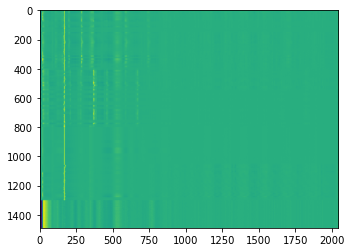

-0.08523857773539902


In [46]:

dataset0=pmma_ds + ps_ds + glass_ds + plga_ds
dataset0=np.array([i.data for i in dataset0])
# dataset0=np.array(training_features0)
print(dataset0.shape)
plt.imshow(dataset0.astype(float))
plt.savefig("datasetImshow.png", dpi=100)
plt.show()
print(dataset0[0][0])